# COMP0188 - Lab 2

Welcome to your second lab session! This week, we will be covering material presented in Lecture 2, conducted on 14 Oct.

Learning objectives:
1. Gain hands-on experience with implementing neural nets in Tensorflow
2. Understand different loss functions and their uses
3. Understand overfitting in terms of bias-variance tradeoff
4. Understand regularization in terms of bias-variance tradeoff

## Part 0 - Prerequisites

### 0.1 - Setup

First, we will ensure all Python libraries are installed and imported

In [5]:
!python -m pip install numpy pandas tensorflow matplotlib seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
import os

print("Imported required modules...")

Imported required modules...


Next, we will configure Pandas display options. These will come in useful down the line

In [7]:
# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

In [10]:
#### Import data from google co-lab ###
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)


train_df = pd.read_csv(r'/content/gdrive/MyDrive/Colab Notebooks/csv/california_housing_train.csv', delimiter=',')
test_df = pd.read_csv(r'/content/gdrive/MyDrive/Colab Notebooks/csv/california_housing_test.csv', delimiter=',')

print(train_df.dtypes, train_df.shape)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
dtype: object (17000, 9)


### 0.2 - Data Download

To start off, we will be exploring the [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description), a historical dataset of various houses, their attributes, and property sale prices. We will use this to train a simple machine learning model for predicting **house prices**. 

Because these are public datasets, they can be downloaded directly from a HTTPS URL, allowing us to get away without mounting Google Drive. Hooray! 

In [ ]:
# Download the train and test dataset
!wget https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv
!wget https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv

--2022-10-17 21:45:48--  https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv
Resolving download.mlcc.google.com (download.mlcc.google.com)... 216.58.212.227, 2a00:1450:4009:80b::2003
Connecting to download.mlcc.google.com (download.mlcc.google.com)|216.58.212.227|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv [following]
--2022-10-17 21:45:48--  https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv
Resolving dl.google.com (dl.google.com)... 216.58.213.14, 2a00:1450:4009:816::200e
Connecting to dl.google.com (dl.google.com)|216.58.213.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1706430 (1.6M) [text/csv]
Saving to: ‘california_housing_train.csv.1’

california_housing_ 100%[===================>]   1.63M  2.19MB/s    in 0.7s    

2022-10-17 21:45:49 (2.19 MB/s) - ‘california_housing_train.csv.1’ saved [1706430/1706

## Part 1 - Neural Nets in Tensorflow

### 1.1 - Data Visualization

First, let's load the data. 

Before starting any machine learning project, it's important to **visualize the data** and see if it makes sense. As the adage goes, a machine learning model is only as good as the data - or, more concisely, **garbage in, garbage out**. 

The datasets come in the form of tables with several rows and columns. Each row is one unique property and each column describes one particular attribute of the property.

We can load the data using Pandas' `read_csv` function. 

In [11]:
train_df = pd.read_csv(r"california_housing_train.csv", delimiter=",")
test_df = pd.read_csv(r"california_housing_test.csv", delimiter=",")


FileNotFoundError: ignored

Now, let's visualize the data! 

Printing the dataframe will print all of its rows and columns. 

In [12]:
train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0
...,...,...,...,...,...,...,...,...,...
16995,-124.3,40.6,52.0,2217.0,394.0,907.0,369.0,2.4,111400.0
16996,-124.3,40.7,36.0,2349.0,528.0,1194.0,465.0,2.5,79000.0
16997,-124.3,41.8,17.0,2677.0,531.0,1244.0,456.0,3.0,103600.0
16998,-124.3,41.8,19.0,2672.0,552.0,1298.0,478.0,2.0,85800.0


Too much information! To avoid overflow, we can print the (num_rows, num_cols) as well as just the first k=5 rows

In [ ]:
print(train_df.shape)
train_df.head()

(17000, 9)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.3,34.2,15.0,5612.0,1283.0,1015.0,472.0,1.5,66900.0
1,-114.5,34.4,19.0,7650.0,1901.0,1129.0,463.0,1.8,80100.0
2,-114.6,33.7,17.0,720.0,174.0,333.0,117.0,1.7,85700.0
3,-114.6,33.6,14.0,1501.0,337.0,515.0,226.0,3.2,73400.0
4,-114.6,33.6,20.0,1454.0,326.0,624.0,262.0,1.9,65500.0


Similarly, let's visualize the test dataframe.

In [ ]:
print(test_df.shape)
test_df.head()

(3000, 9)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.0,37.4,27.0,3885.0,661.0,1537.0,606.0,6.6,344700.0
1,-118.3,34.3,43.0,1510.0,310.0,809.0,277.0,3.6,176500.0
2,-117.8,33.8,27.0,3589.0,507.0,1484.0,495.0,5.8,270500.0
3,-118.4,33.8,28.0,67.0,15.0,49.0,11.0,6.1,330000.0
4,-119.7,36.3,19.0,1241.0,244.0,850.0,237.0,2.9,81700.0


### 1.2 - Data Preprocessing

When building a model with multiple features, a common practice is to **normalize** the data so that the values of each feature are of approximately the same magnitude. For example, normalizing all features to have mean 0 and standard deviation of 1. Normalizing the features helps the model learn better.

The following code cell normalizes both datasets to have mean 0 and standard deviation of 1. 


In [ ]:
#@title Convert raw values to their Z-scores 

# Calculate the Z-scores of each column in the training set:
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Calculate the Z-scores of each column in the test set.
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

print("Normalized the values.")

Normalized the values.


### 1.3 - Feature Extraction

Sometimes, it is a good idea to create additional features in the dataset. This is mostly true in the cases where you have intuition that a certain feature is important for prediction but is not included in the dataset. 

Although neural nets are capable of learning to do their own feature extraction, manually extracting important features can offload some of that computational burden and allow for faster learning. 

#### Technical notes: 

The following code cell creates a feature layer containing three features:
1. latitude X longitude (a feature cross)
2. median_income
3. population

This code cell specifies the features that you'll ultimately train the model on and how each of those features will be represented. Because of the way Tensorflow is implemented, the transformations (collected in my_feature_layer) don't actually get applied until you pass a DataFrame to it, which will happen when we train the model.

In [ ]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# We scaled all the columns, including latitude and longitude, into their
# Z scores. So, instead of picking a resolution in degrees, we're going
# to use resolution_in_Zs.  A resolution_in_Zs of 1 corresponds to 
# a full standard deviation. 
resolution_in_Zs = 0.3  # 3/10 of a standard deviation.

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df_norm['latitude'])), 
                                     int(max(train_df_norm['latitude'])), 
                                     resolution_in_Zs))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, latitude_boundaries)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df_norm['longitude'])), 
                                      int(max(train_df_norm['longitude'])), 
                                      resolution_in_Zs))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)  

# Represent median_income as a floating-point value.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Represent population as a floating-point value.
population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

### 1.4 - Build a baseline model

In developing a machine learning workflow, it's very helpful to **start simple** with a baseline model. Starting with a simple baseline gives us confidence that the other parts of our pipeline are working as intended, and also gives us a target to aim to succeed with deeper architectures. 

In our case, we will build a **linear regression** model that uses the feature layer we just created.

In [ ]:
#@title Define functions to create and train a linear regression model
def create_baseline_model(my_learning_rate, feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model    

We'll also define some helper functions to run the training and visualize the training results. 

In [ ]:
#@title Define the plotting function.

def train_model(model, dataset, epochs, batch_size, label_name):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  rmse = hist["mean_squared_error"]

  return epochs, rmse   

print("Defined the create_model and train_model functions.")

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  

print("Defined the plot_the_loss_curve function.")

Defined the create_model and train_model functions.
Defined the plot_the_loss_curve function.


Lastly, we'll start the actual training run.

Epoch 1/15
17/17 [==============================] - 0s 1ms/step - loss: 0.7610 - mean_squared_error: 0.7610
Epoch 2/15
17/17 [==============================] - 0s 1ms/step - loss: 0.5336 - mean_squared_error: 0.5336
Epoch 3/15
17/17 [==============================] - 0s 945us/step - loss: 0.4324 - mean_squared_error: 0.4324
Epoch 4/15
17/17 [==============================] - 0s 989us/step - loss: 0.3874 - mean_squared_error: 0.3874
Epoch 5/15
17/17 [==============================] - 0s 956us/step - loss: 0.3708 - mean_squared_error: 0.3708
Epoch 6/15
17/17 [==============================] - 0s 929us/step - loss: 0.3648 - mean_squared_error: 0.3648
Epoch 7/15
17/17 [==============================] - 0s 928us/step - loss: 0.3619 - mean_squared_error: 0.3619
Epoch 8/15
17/17 [==============================] - 0s 938us/step - loss: 0.3608 - mean_squared_error: 0.3608
Epoch 9/15
17/17 [==============================] - 0s 957us/step - loss: 0.3603 - mean_squared_error: 0.3603
Epoch 10/15
17

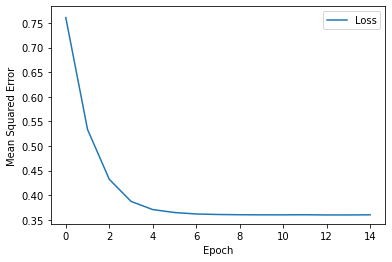


 Evaluate the linear regression model against the test set:
3/3 [==============================] - 0s 1ms/step - loss: 0.3952 - mean_squared_error: 0.3952


[0.3952183425426483, 0.3952183425426483]

In [ ]:
# Suppress the numerous warnings
import warnings
warnings.filterwarnings("ignore")

# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_baseline_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the linear regression model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

What was the final `mean_squared_error` for the training and testing sets? Write down your findings below.

In [ ]:
# Your notes here

### Part 2 - Deep Neural Networks

Now it's your turn! Apply the concepts you've just learned. 

#### Exercise 2.1 - Build a DNN

Train a neural net with 2 hidden layers of sizes (20, 12) respectively. We've provided some starter code for you below. You can re-use the `train_model` and `plot_the_loss_curve` functions defined above.


In [ ]:
def create_my_model(my_learning_rate, my_feature_layer):
  """Create and compile a deep neural net model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  ##################
  # YOUR CODE HERE #
  ##################
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

#### Exercise 2.1 - Solutions

In [ ]:
def create_my_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  # Define the first hidden layer with 20 nodes.   
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  # Define the second hidden layer with 12 nodes. 
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  name='Hidden2'))
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

Run the following cell to perform the training with your newly-defined model

Epoch 1/15
17/17 [==============================] - 0s 1ms/step - loss: 0.8141 - mean_squared_error: 0.8141
Epoch 2/15
17/17 [==============================] - 0s 1ms/step - loss: 0.5129 - mean_squared_error: 0.5129
Epoch 3/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3597 - mean_squared_error: 0.3597
Epoch 4/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3417 - mean_squared_error: 0.3417
Epoch 5/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3353 - mean_squared_error: 0.3353
Epoch 6/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3329 - mean_squared_error: 0.3329
Epoch 7/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3318 - mean_squared_error: 0.3318
Epoch 8/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3299 - mean_squared_error: 0.3299
Epoch 9/15
17/17 [==============================] - 0s 1ms/step - loss: 0.3293 - mean_squared_error: 0.3293
Epoch 10/15
17/17 [=========

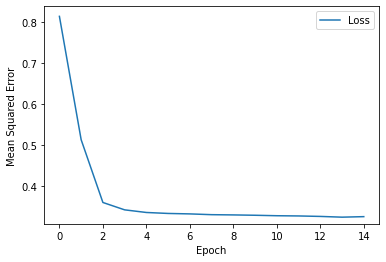


 Evaluate the DNN model against the test set:
3/3 [==============================] - 0s 2ms/step - loss: 0.3643 - mean_squared_error: 0.3643


[0.3643138110637665, 0.3643138110637665]

In [ ]:
# Suppress the numerous warnings
import warnings
warnings.filterwarnings("ignore")

# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Establish the model's topography.
my_model = create_my_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, batch_size, label_name)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the DNN model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)

What were the training and testing mean squared errors? Write down your answers below.

In [ ]:
# Your notes here

#### 2.2 - Experiment with Learning Rates

Now, experiment with at least 2 other learning rates with a deep net and compare the results. Write down which learning rates you tried and which one worked best. 



In [ ]:
# Your notes here

Discuss the following questions with your peers:
* What are the advantages of a high learning rate? 
* What are the advantages of a low learning rate? 

#### 2.3 - Experiment with Different Layer Sizes

Now experiment with at least 2 different combinations of layer sizes (or introduce more layers, or fewer layers). For example: build a three-hidden-layer network with hidden layer sizes (10, 6, 3) . Or a 1-hidden-layer network with size (20,). Use your imagination! (or a random number generator)

Write down which combinations you tried and which one worked best. 

In [ ]:
# Your notes here

Discuss the following questions with your peers:
* What are the advantages of having more layers? 
* What are the advantages of having fewer layers? 

### Discussion

You may have noticed the following trends:
* Two layers outperformed one layer, but 
three layers did not perform significantly 
     better than two layers; two layers 
     outperformed one layer.
     In other words, two layers seemed best. 
* Setting the topography as follows produced 
     reasonably good results with relatively few 
     nodes:
    * 10 nodes in the first layer.
    *  6 nodes in the second layer.

As the number of nodes in each layer dropped
below the preceding, test loss increased.  
However, depending on your application, hardware
constraints, and the relative pain inflicted 
by a less accurate model, a smaller network 
(for example, 6 nodes in the first layer and 
4 nodes in the second layer) might be 
acceptable.

### Part 3 - Overfitting  

You have learned in class that overfitting happens because the model is **too expressive** - it learns to memorize the random noises in the training data, which ultimately do not transfer to the test data. 

A common way to combat this is by regularization.



#### 3.1 - Regularizations

Notice that the model's loss against the test set is *much higher* than the loss against the training set.  In other words, the deep neural network is [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting) to the data in the training set.  To reduce overfitting, regularize the model.  There several different ways to regularize a model, including:

  * [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization)
  * [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization)
  * [Dropout regularization](https://developers.google.com/machine-learning/glossary/#dropout_regularization)

Your task is to experiment with one or more regularization mechanisms to bring the test loss closer to the training loss (while still keeping test loss relatively low).  

**Note:** When you add a regularization function to a model, you might need to tweak other hyperparameters. 

##### Implementing L1 or L2 regularization

To use L1 or L2 regularization on a hidden layer, specify the `kernel_regularizer` argument to [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). Assign one of the following methods to this argument:

* `tf.keras.regularizers.l1` for L1 regularization
* `tf.keras.regularizers.l2` for L2 regularization

Each of the preceding methods takes an `l` parameter, which adjusts the [regularization rate](https://developers.google.com/machine-learning/glossary/#regularization_rate). Assign a decimal value between 0 and 1.0 to `l`; the higher the decimal, the greater the regularization. For example, the following applies L2 regularization at a strength of 0.01. 

```
model.add(tf.keras.layers.Dense(units=20, 
                                activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(l=0.01),
                                name='Hidden1'))
```

##### Implementing Dropout regularization

You implement dropout regularization as a separate layer in the topography.For example, the following code demonstrates how to add a dropout regularization layer between the first hidden layer and the second hidden layer:

```
model.add(tf.keras.layers.Dense( *define first hidden layer*)
 
model.add(tf.keras.layers.Dropout(rate=0.25))

model.add(tf.keras.layers.Dense( *define second hidden layer*)
```

The `rate` parameter to [tf.keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) specifies the fraction of nodes that the model should drop out during training. 


#### Exercise 3.2 - Implementing Regularization

In [ ]:
def create_regularized_model(my_learning_rate, my_feature_layer):
  """Create and compile a deep neural net model with regularization."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  ##################
  # YOUR CODE HERE #
  ##################
  
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

### Exercise 3.2 - Solution

In [ ]:
## HIDDERN FROM STUDENTS

# The following "solution" uses L2 regularization to bring training loss
# and test loss closer to each other. Many, many other solutions are possible.


def create_regularized_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""

  # Discard any pre-existing version of the model.
  model = None

  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model. 

  # Implement L2 regularization in the first hidden layer.
  model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.04),
                                  name='Hidden1'))
  
  # Implement L2 regularization in the second hidden layer.
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  kernel_regularizer=tf.keras.regularizers.l2(0.04),
                                  name='Hidden2'))

  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  name='Output'))                              
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model     

# Call the new create_model function and the other (unchanged) functions.

#### 3.3 - Training a regularized model

When you're done with the above, run the following code cell to train a regularized deep neural net.

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.007
epochs = 140
batch_size = 1000

label_name = "median_house_value"

# Establish the model's topography.
my_model = create_regularized_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, train_df_norm, epochs, 
                          label_name, batch_size)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in test_df_norm.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size) 

#### Exercise 3.4 - Discussion

Discuss with your peers:
* Why does regularization reduce overfitting?

Hint: think about what causes a model to overfit. 

#### Exercise 3.4 - Solutions

Regularization reduces overfitting by *biasing* the learning algorithm towards a subset of the available parameter space, thereby reducing the *effective* expressivity of the model.